In [138]:
import os
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%run Module-2-helper.py
def read_from_files(directory, start, end):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f>=start+'.pkl' and f<=end+'.pkl']
    frames = []
    for f in files:
        df = pd.read_pickle(f)
        frames.append(df)
        del df
    df_final = pd.concat(frames)
    df_final=df_final.sort_values('TRANSACTION_ID')
    df_final.reset_index(drop=True,inplace=True)
    df_final=df_final.replace([-1],0) # marking the missing values
    return df_final

### For Visualization, 2-D PCA transfer the data

In [78]:
INPUT = './simulated-data-transformed' 
Output = "2022-01-15"
END_DATE = "2022-04-20"
transactions_df = read_from_files(INPUT, Output, END_DATE)
output_feature = "Trans_FRAUD"
input_features = ['Trans_AMOUNT','Trans_DURING_WEEKEND', 'Trans_DURING_NIGHT', 'CUSTOMER_ID_NB_Trans_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_Trans_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_Trans_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'STORE_ID_NB_Trans_1DAY_WINDOW',
       'STORE_ID_RISK_1DAY_WINDOW', 'STORE_ID_NB_Trans_7DAY_WINDOW',
       'STORE_ID_RISK_7DAY_WINDOW', 'STORE_ID_NB_Trans_30DAY_WINDOW',
       'STORE_ID_RISK_30DAY_WINDOW']

Load  files
2323689 transactions loaded, containing 28085 fraudulent transactions


In [79]:
x = transactions_df.loc[:, input_features].values
y = transactions_df.loc[:,['Trans_FRAUD']].values
x = StandardScaler().fit_transform(x)

In [80]:
pca = PCA(n_components=2)
pca = pca.fit_transform(x)
pcadf = pd.DataFrame(data = pca
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([pcadf, transactions_df[['Trans_FRAUD']]], axis = 1)
dataset_df = finalDf.rename(columns={"principal component 1" : "X1", "principal component 2" : "X2", "Trans_FRAUD": "Y"})

In [83]:
dataset_df

,X1,X2,Y
0,-2.603049,-2.787673,0
1,2.964918,-0.523324,0
2,-3.068767,-3.056342,0
3,2.441209,-1.895310,0
4,-2.183463,-0.633554,0
...,...,...,...
2323684,0.847092,1.097523,0
2323685,0.534685,1.877736,0
2323686,0.477369,1.143788,0
2323687,-2.723357,1.631916,0


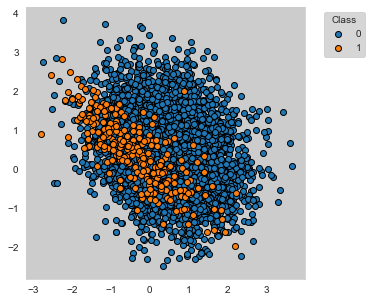

In [86]:
X, y = dataset_df[["X1", "X2"]], dataset_df[["Y"]]
fig_distribution, ax = plt.subplots(1, 1, figsize=(5,5))
groups = dataset_df.groupby('Y')
for name, group in groups:
    ax.scatter(group.X1, group.X2, edgecolors='k', label=name,alpha=1,marker='o')
ax.legend(loc='upper left', 
          bbox_to_anchor=(1.05, 1),
          title="Class")

## Decision-Trees - Tacking Imbalance using the Cost-Sensitive Learning
---

In [116]:
cls = sklearn.tree.DecisionTreeClassifier(max_depth=10,class_weight={0:1,1:1},random_state=0)
cross_v = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
cross_v_res = sklearn.model_selection.cross_validate(cls, X, y, cv=cross_v,
                                                     scoring=['roc_auc','average_precision','balanced_accuracy'],
                                                     return_estimator=True)
res = round(pd.DataFrame(cross_v_res),3)
res

,fit_time,score_time,estimator,test_roc_auc,test_average_precision,test_balanced_accuracy
0,0.005,0.001,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.678,0.133,0.544
1,0.005,0.001,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.719,0.126,0.499
2,0.006,0.001,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.663,0.117,0.512
3,0.005,0.001,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.725,0.162,0.552
4,0.005,0.001,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.715,0.156,0.559


In [117]:
res_mean = list(res.mean().values)
res_std = list(res.std().values)
pd.DataFrame([[str(round(res_mean[i],3))+'+/-'+str(round(res_std[i],3)) for i in range(len(res))]],
            columns=['Time','Score time','AUC ROC - Metric-1','Average Precision - Metric-2','Balanced accuracy- Metric-1'])

/var/folders/vb/1nttnwc116l2y0t3v_x1pqqc0000gn/T/ipykernel_9109/1367335016.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  res_mean = list(res.mean().values)
/var/folders/vb/1nttnwc116l2y0t3v_x1pqqc0000gn/T/ipykernel_9109/1367335016.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  res_std = list(res.std().values)


,Time,Score time,AUC ROC - Metric-1,Average Precision - Metric-2,Balanced accuracy- Metric-1
0,0.005+/-0.0,0.001+/-0.0,0.7+/-0.028,0.139+/-0.019,0.533+/-0.026


In [118]:
cls_tar = cross_v_res['estimator'][0]

In [119]:
# Retrieve the indices used for the training and testing of the first fold of the cross-validation
(train_index, test_index) = next(cross_v.split(X, y))

# Recreate the train and test DafaFrames from these indices
train_df = pd.DataFrame({'X1':X[train_index,0], 'X2':X[train_index,1], 'Y':y[train_index]})
test_df = pd.DataFrame({'X1':X[test_index,0], 'X2':X[test_index,1], 'Y':y[test_index]})
input_features = ['X1','X2', 'X3']
output_feature = 'Y'

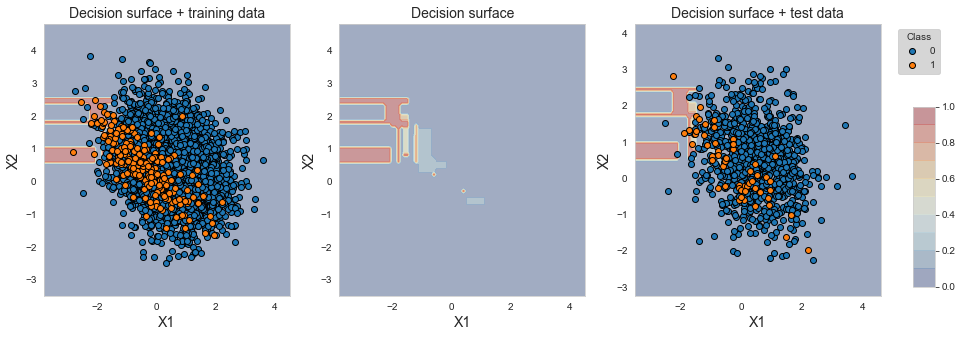

In [120]:
fig_decision_boundary, ax = plt.subplots(1, 3, figsize=(5*3,5))
def plot_decision_boundary_classifier(ax, cls,train_df,input_features=['X1','X2'],output_feature='Y',title="",fs=14,
plot_training_data=True):
    plot_colors = ["tab:blue","tab:orange"]
    x1_min, x1_max = train_df[input_features[0]].min() - 1, train_df[input_features[0]].max() + 1
    x2_min, x2_max = train_df[input_features[1]].min() - 1, train_df[input_features[1]].max() + 1
    plot_step=0.1
    xx, yy = np.meshgrid(np.arange(x1_min, x1_max, plot_step), np.arange(x2_min, x2_max, plot_step))
    Z = cls.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu_r,alpha=0.3)
    if plot_training_data:
        # Plot the training points
        groups = train_df.groupby(output_feature)
        for name, group in groups:
            ax.scatter(group[input_features[0]], group[input_features[1]], edgecolors='black', label=name)
    ax.set_title(title, fontsize=fs)
    ax.set_xlabel(input_features[0], fontsize=fs)
    ax.set_ylabel(input_features[1], fontsize=fs)

plot_decision_boundary_classifier(ax[0], cls_tar,train_df,title="Decision surface + training data",plot_training_data=True)
plot_decision_boundary_classifier(ax[1], cls_tar,train_df,title="Decision surface",plot_training_data=False)
plot_decision_boundary_classifier(ax[2], cls_tar,test_df,title="Decision surface + test data",plot_training_data=True)

ax[-1].legend(loc='upper left', 
              bbox_to_anchor=(1.05, 1),
              title="Class")

sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlBu_r, norm=plt.Normalize(vmin=0, vmax=1))
cax = fig_decision_boundary.add_axes([0.93, 0.15, 0.02, 0.5])
fig_decision_boundary.colorbar(sm, cax=cax, alpha=0.3, boundaries=np.linspace(0, 1, 11))

/Users/dayevan/Desktop/Final-Module-2/Module-2-helper.py:460: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_mean = list(results.mean().values)
/Users/dayevan/Desktop/Final-Module-2/Module-2-helper.py:461: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_std = list(results.std().values)


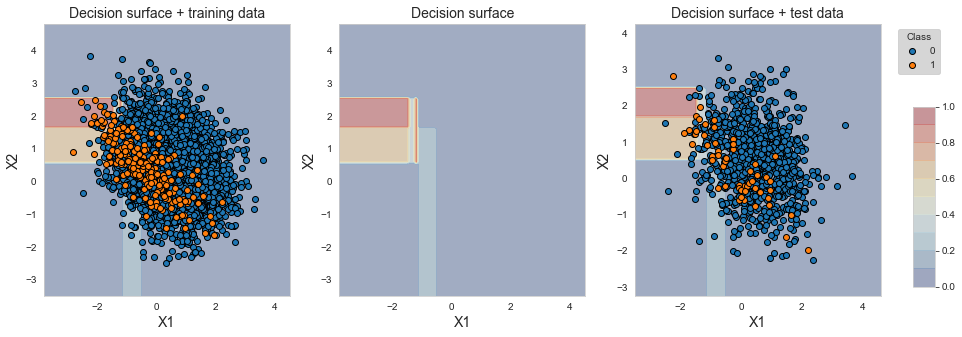

In [131]:
cls = sklearn.tree.DecisionTreeClassifier(max_depth=5,class_weight={0:1,1:1},random_state=0)
(res_dt_base, cls_tar, train_df, test_df) = cs_classifer(cls, X, y, n_splits=5, name="Decision tree - Baseline")
fig_decision_boundary = boundary(cls_tar, train_df, test_df)

### Adding Cost-Sensitive

/Users/dayevan/Desktop/Final-Module-2/Module-2-helper.py:460: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_mean = list(results.mean().values)
/Users/dayevan/Desktop/Final-Module-2/Module-2-helper.py:461: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_std = list(results.std().values)


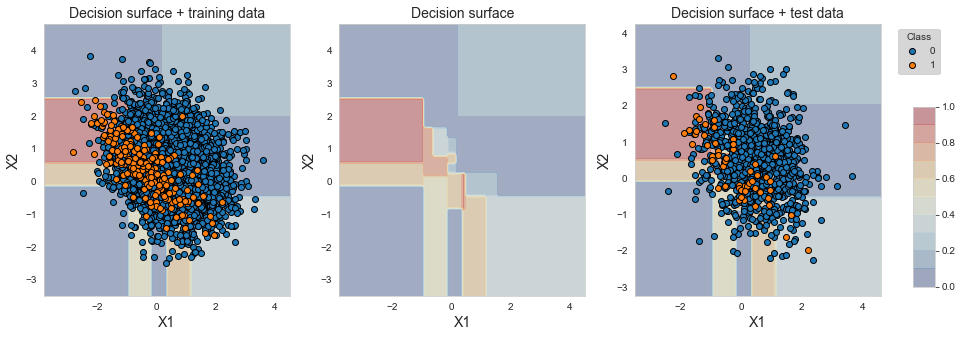

In [132]:
IR=0.05/0.95
class_weight={0:IR,1:1}
cls = sklearn.tree.DecisionTreeClassifier(max_depth=5,class_weight=class_weight,random_state=0)
(res_dt_cs, cls_tar, train_df, test_df) = cs_classifer(cls, X, y, n_splits=5, name="Decision tree - Cost-sensitive")
fig_decision_boundary = boundary(cls_tar, train_df, test_df)

In [133]:
pd.concat([res_dt_base, res_dt_cs])

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Decision tree - Baseline,0.003+/-0.001,0.001+/-0.0,0.776+/-0.036,0.176+/-0.042,0.52+/-0.019
Decision tree - Cost-sensitive,0.004+/-0.001,0.001+/-0.0,0.783+/-0.016,0.193+/-0.039,0.715+/-0.021


# Same for the Logistic Regreesion 

/Users/dayevan/Desktop/Final-Module-2/Module-2-helper.py:460: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_mean = list(results.mean().values)
/Users/dayevan/Desktop/Final-Module-2/Module-2-helper.py:461: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_std = list(results.std().values)


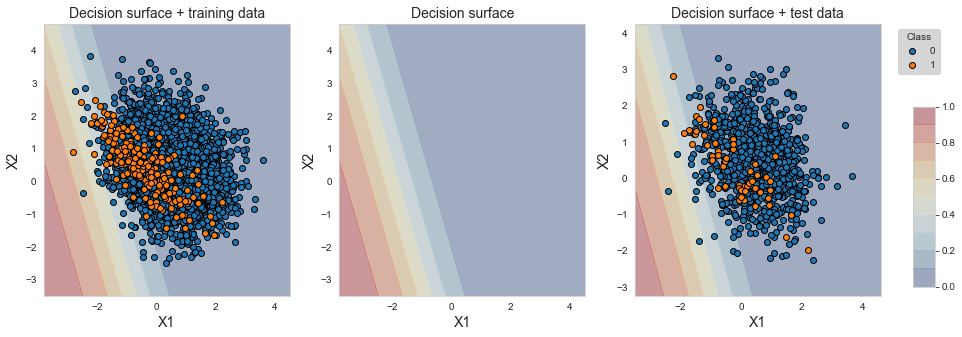

In [139]:
cls = sklearn.linear_model.LogisticRegression(C=1,class_weight={0:1,1:1},random_state=0)
(res_lr_base, cls_tar, train_df, test_df) = cs_classifer(cls, X, y, n_splits=5,name="Logistic regression - Baseline")
fig_decision_boundary = boundary(cls_tar, train_df, test_df)

In [99]:
res_lr_base

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Logistic regression - Baseline,0.003+/-0.002,0.001+/-0.0,0.789+/-0.038,0.183+/-0.048,0.501+/-0.004


### Adding Cost-Sensitive

/Users/dayevan/Desktop/Final-Module-2/Module-2-helper.py:460: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_mean = list(results.mean().values)
/Users/dayevan/Desktop/Final-Module-2/Module-2-helper.py:461: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_std = list(results.std().values)


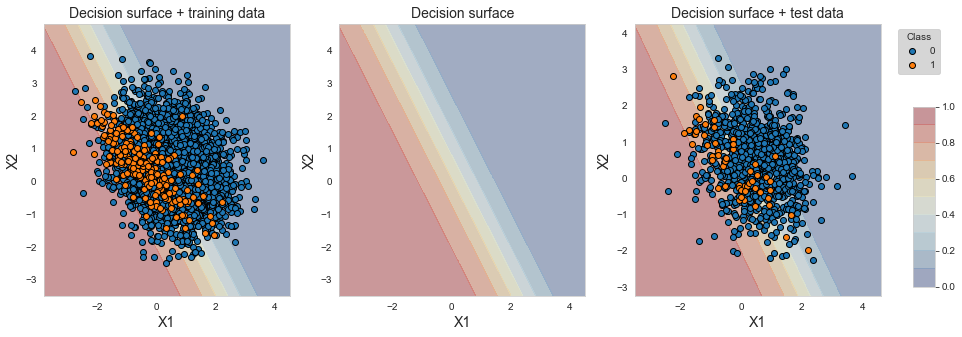

In [140]:
cls = sklearn.linear_model.LogisticRegression(C=1,class_weight={0:IR,1:1},random_state=0)
(res_lr_css, cls_tar, train_df, test_df) = cs_classifer(cls, X, y, n_splits=5,name="Logistic regression - Cost-sensitive")
fig_decision_boundary = boundary(cls_tar, train_df, test_df)

In [101]:
pd.concat([res_lr_base, res_lr_css])

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Logistic regression - Baseline,0.003+/-0.002,0.001+/-0.0,0.789+/-0.038,0.183+/-0.048,0.501+/-0.004
Logistic regression - Cost-sensitive,0.002+/-0.0,0.001+/-0.0,0.797+/-0.032,0.151+/-0.038,0.743+/-0.026


In [102]:
res_df = pd.concat([res_dt_base,res_dt_cs,res_lr_base,res_lr_css])
res_df

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Decision tree - Baseline,0.003+/-0.001,0.001+/-0.0,0.776+/-0.036,0.176+/-0.042,0.52+/-0.019
Decision tree - Cost-sensitive,0.003+/-0.001,0.001+/-0.0,0.783+/-0.016,0.193+/-0.039,0.715+/-0.021
Logistic regression - Baseline,0.003+/-0.002,0.001+/-0.0,0.789+/-0.038,0.183+/-0.048,0.501+/-0.004
Logistic regression - Cost-sensitive,0.002+/-0.0,0.001+/-0.0,0.797+/-0.032,0.151+/-0.038,0.743+/-0.026
